# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 2000-3000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 


In [34]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 14:58:21.594509
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [35]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=2000
MAXLEN=3000   

In [36]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [37]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [38]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=1
all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 1 = H1.hESC


## Data Load

In [39]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [40]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 14:58:24.598114
Load RCI values...
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2022-12-29 14:58:24.628938
Load sequence...
2022-12-29 14:58:37.678135
Num IDs: 11162
Example IDs: [('ENSG00000078808', 'ENST00000263741.12'), ('ENSG00000224051', 'ENST00000343938.9'), ('ENSG00000197530', 'ENST00000378712.5'), ('ENSG00000008128', 'ENST00000356200.7')]
Count 5073 ones out of 11162 labels.
Example labels: [0, 1, 0, 0]
Num counts: 11162
Example sequence: [160, 126, 247, 219, 107, 172, 176, 191, 251, 236, 175, 188, 238, 181, 212, 79, 59, 234, 165, 147, 74, 40, 159, 122, 231, 155, 107, 171, 169, 163, 138, 38, 151, 90, 101, 145, 67, 9, 35, 139, 42, 167, 154, 102, 152, 95, 123, 234, 167, 155, 105, 163, 138, 40, 159, 121, 226, 135, 27, 108, 175, 187, 233, 162, 135, 25, 99, 140, 48, 190, 246, 216, 93, 115, 202, 40, 160, 126, 247, 219, 107, 170, 168, 160, 128, 255, 249, 226, 136, 30, 118, 215, 89, 99, 1

## Model

In [41]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [42]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 14:58:37.719191
COMPILE
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 2997, 4)           1028      
                                                                 
 conv1d_18 (Conv1D)          (None, 2990, 64)          2112      
                                                                 
 global_average_pooling1d_18  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_37 (Dense)            (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [43]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 14:58:38.029063
2022-12-29 14:58:38.029586
splitting
Fold 1
Training example
[147  73  35 ...   0   0   0]
Train sizes (8855, 2997) (8855, 1)
Valid sizes (2307, 2997) (2307, 1)
Train set ones/size 4006 / 8855
Valid set ones/size 1067 / 2307
BUILD MODEL
COMPILE
FIT
2022-12-29 14:58:40.028790
Epoch 1/5
277/277 [==============================] - 3s 7ms/step - loss: 0.5996 - accuracy: 0.6761 - val_loss: 0.5373 - val_accuracy: 0.7278
Epoch 2/5
277/277 [==============================] - 2s 6ms/step - loss: 0.5556 - accuracy: 0.7260 - val_loss: 0.5371 - val_accuracy: 0.7256
Epoch 3/5
277/277 [==============================] - 2s 6ms/step - loss: 0.5474 - accuracy: 0.7313 - val_loss: 0.5221 - val_accuracy: 0.7469
Epoch 4/5
277/277 [==============================] - 2s 6ms/step - loss: 0.5384 - accuracy: 0.7420 - val_loss: 0.5144 - val_accuracy: 0.7534
Epoch 5/5
277/277 [==============================] - 2s 6ms/step - loss: 0.5297 - accuracy: 0.7461 - val_loss: 0.5155 - val_accuracy:

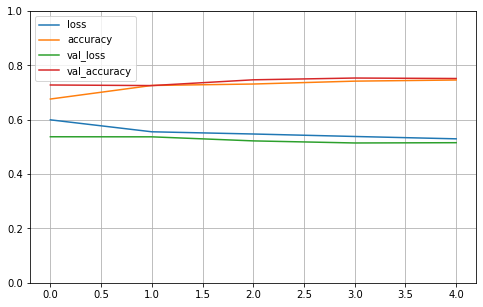

Compute valiation accuracy
2022-12-29 14:58:51.126278
Range of scores: 0.015581591 to 0.9666327
Predicted zeros and ones 1109 1198
Accuracy: 75.16% Precision: 70.62% Recall: 79.29% F1: 74.70%
2022-12-29 14:58:51.545041
Fold 2
Training example
[147  73  35 ...   0   0   0]
Train sizes (8942, 2997) (8942, 1)
Valid sizes (2220, 2997) (2220, 1)
Train set ones/size 4116 / 8942
Valid set ones/size 957 / 2220
BUILD MODEL
COMPILE
FIT
2022-12-29 14:58:53.505692
Epoch 1/5
280/280 [==============================] - 3s 7ms/step - loss: 0.5928 - accuracy: 0.6760 - val_loss: 0.5528 - val_accuracy: 0.7356
Epoch 2/5
280/280 [==============================] - 2s 6ms/step - loss: 0.5502 - accuracy: 0.7286 - val_loss: 0.5450 - val_accuracy: 0.7423
Epoch 3/5
280/280 [==============================] - 2s 6ms/step - loss: 0.5414 - accuracy: 0.7379 - val_loss: 0.5477 - val_accuracy: 0.7396
Epoch 4/5
280/280 [==============================] - 2s 6ms/step - loss: 0.5304 - accuracy: 0.7436 - val_loss: 0.5461 - 

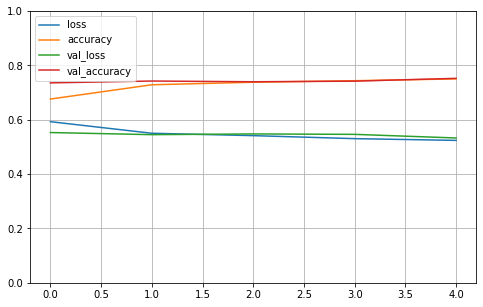

Compute valiation accuracy
2022-12-29 14:59:03.551002
Range of scores: 0.0059695 to 0.95845574
Predicted zeros and ones 1323 897
Accuracy: 75.23% Precision: 72.69% Recall: 68.13% F1: 70.33%
2022-12-29 14:59:03.968458
Fold 3
Training example
[147  73  35 ...   0   0   0]
Train sizes (8841, 2997) (8841, 1)
Valid sizes (2321, 2997) (2321, 1)
Train set ones/size 4031 / 8841
Valid set ones/size 1042 / 2321
BUILD MODEL
COMPILE
FIT
2022-12-29 14:59:05.910642
Epoch 1/5
277/277 [==============================] - 3s 7ms/step - loss: 0.5912 - accuracy: 0.6792 - val_loss: 0.5623 - val_accuracy: 0.7277
Epoch 2/5
277/277 [==============================] - 2s 6ms/step - loss: 0.5477 - accuracy: 0.7293 - val_loss: 0.5526 - val_accuracy: 0.7363
Epoch 3/5
277/277 [==============================] - 2s 6ms/step - loss: 0.5363 - accuracy: 0.7374 - val_loss: 0.5457 - val_accuracy: 0.7419
Epoch 4/5
277/277 [==============================] - 2s 7ms/step - loss: 0.5254 - accuracy: 0.7474 - val_loss: 0.5517 - v

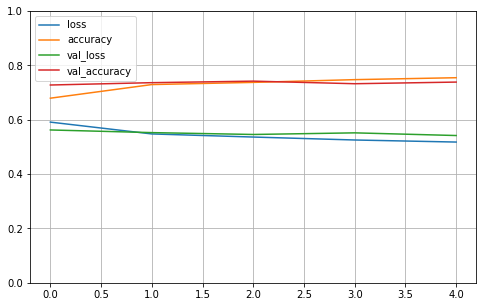

Compute valiation accuracy
2022-12-29 14:59:17.007858
Range of scores: 0.008652275 to 0.9735108
Predicted zeros and ones 1288 1033
Accuracy: 73.85% Precision: 71.06% Recall: 70.44% F1: 70.75%
2022-12-29 14:59:17.426427
Fold 4
Training example
[147  73  35 ...   0   0   0]
Train sizes (8999, 2997) (8999, 1)
Valid sizes (2163, 2997) (2163, 1)
Train set ones/size 4108 / 8999
Valid set ones/size 965 / 2163
BUILD MODEL
COMPILE
FIT
2022-12-29 14:59:19.396294
Epoch 1/5
282/282 [==============================] - 3s 7ms/step - loss: 0.5950 - accuracy: 0.6840 - val_loss: 0.5558 - val_accuracy: 0.7291
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: 0.5504 - accuracy: 0.7257 - val_loss: 0.5491 - val_accuracy: 0.7323
Epoch 3/5
282/282 [==============================] - 2s 6ms/step - loss: 0.5407 - accuracy: 0.7361 - val_loss: 0.5428 - val_accuracy: 0.7402
Epoch 4/5
282/282 [==============================] - 2s 7ms/step - loss: 0.5306 - accuracy: 0.7459 - val_loss: 0.5384 - 

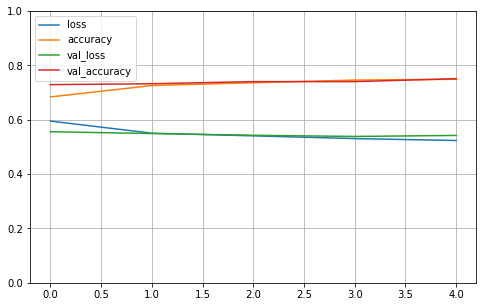

Compute valiation accuracy
2022-12-29 14:59:30.450620
Range of scores: 0.00922448 to 0.9687228
Predicted zeros and ones 1069 1094
Accuracy: 75.08% Precision: 69.47% Recall: 78.76% F1: 73.82%
2022-12-29 14:59:30.728340
Fold 5
Training example
[160 126 247 ...   0   0   0]
Train sizes (9011, 2997) (9011, 1)
Valid sizes (2151, 2997) (2151, 1)
Train set ones/size 4031 / 9011
Valid set ones/size 1042 / 2151
BUILD MODEL
COMPILE
FIT
2022-12-29 14:59:32.707300
Epoch 1/5
282/282 [==============================] - 3s 7ms/step - loss: 0.5895 - accuracy: 0.6794 - val_loss: 0.5775 - val_accuracy: 0.7020
Epoch 2/5
282/282 [==============================] - 2s 6ms/step - loss: 0.5473 - accuracy: 0.7321 - val_loss: 0.5623 - val_accuracy: 0.7197
Epoch 3/5
282/282 [==============================] - 3s 9ms/step - loss: 0.5382 - accuracy: 0.7429 - val_loss: 0.5543 - val_accuracy: 0.7187
Epoch 4/5
282/282 [==============================] - 3s 10ms/step - loss: 0.5293 - accuracy: 0.7482 - val_loss: 0.5448 -

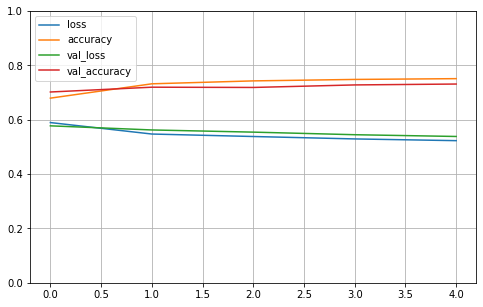

Compute valiation accuracy
2022-12-29 14:59:45.036025
Range of scores: 0.008221558 to 0.9688867
Predicted zeros and ones 1079 1072
Accuracy: 73.13% Precision: 71.64% Recall: 73.70% F1: 72.66%
2022-12-29 14:59:45.462905

Cross validation 5 folds 5 epochs
 accuracy mean 74.49% +/- 0.85
 precision mean 71.09% +/- 1.07
 recall mean 74.06% +/- 4.42
 F1 mean 72.45% +/- 1.70
2022-12-29 14:59:45.466907


In [44]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())